In [48]:
import pandas as pd
import numpy as np

In [49]:
df = pd.read_csv('job_descriptions.csv')

In [50]:
df.dropna(inplace=True)
df.drop('Job Id', axis=1, inplace=True)
df.head()


,Experience,Qualifications,Salary Range,location,Country,latitude,longitude,Work Type,Company Size,Job Posting Date,Preference,Contact Person,Contact,Job Title,Role,Job Portal,Job Description,Benefits,skills,Responsibilities,Company,Company Profile
0,5 to 15 Years,M.Tech,$59K-$99K,Douglas,Isle of Man,54.2361,-4.5481,Intern,26801,2022-04-24,Female,Brandon Cunningham,001-381-930-7517x737,Digital Marketing Specialist,Social Media Manager,Snagajob,Social Media Managers oversee an organizations...,"{'Flexible Spending Accounts (FSAs), Relocatio...","Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",Icahn Enterprises,"{""Sector"":""Diversified"",""Industry"":""Diversifie..."
1,2 to 12 Years,BCA,$56K-$116K,Ashgabat,Turkmenistan,38.9697,59.5563,Intern,100340,2022-12-19,Female,Francisco Larsen,461-509-4216,Web Developer,Frontend Web Developer,Idealist,Frontend Web Developers design and implement u...,"{'Health Insurance, Retirement Plans, Paid Tim...","HTML, CSS, JavaScript Frontend frameworks (e.g...","Design and code user interfaces for websites, ...",PNC Financial Services Group,"{""Sector"":""Financial Services"",""Industry"":""Com..."
2,0 to 12 Years,PhD,$61K-$104K,Macao,"Macao SAR, China",22.1987,113.5439,Temporary,84525,2022-09-14,Male,Gary Gibson,9687619505,Operations Manager,Quality Control Manager,Jobs2Careers,Quality Control Managers establish and enforce...,"{'Legal Assistance, Bonuses and Incentive Prog...",Quality control processes and methodologies St...,Establish and enforce quality control standard...,United Services Automobile Assn.,"{""Sector"":""Insurance"",""Industry"":""Insurance: P..."
3,4 to 11 Years,PhD,$65K-$91K,Porto-Novo,Benin,9.3077,2.3158,Full-Time,129896,2023-02-25,Female,Joy Lucero,+1-820-643-5431x47576,Network Engineer,Wireless Network Engineer,FlexJobs,"Wireless Network Engineers design, implement, ...","{'Transportation Benefits, Professional Develo...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",Hess,"{""Sector"":""Energy"",""Industry"":""Mining, Crude-O..."
4,1 to 12 Years,MBA,$64K-$87K,Santiago,Chile,-35.6751,-71.5429,Intern,53944,2022-10-11,Female,Julie Johnson,343.975.4702x9340,Event Manager,Conference Manager,Jobs2Careers,A Conference Manager coordinates and manages c...,"{'Flexible Spending Accounts (FSAs), Relocatio...",Event planning Conference logistics Budget man...,Specialize in conference and convention planni...,Cairn Energy,"{""Sector"":""Energy"",""Industry"":""Energy - Oil & ..."


In [51]:
df[['min_exp', 'max_exp']] = df['Experience'].str.split(' to ', expand=True)
df['max_exp'] = df['max_exp'].str.replace(' Years', '')
df.head()

,Experience,Qualifications,Salary Range,location,Country,latitude,longitude,Work Type,Company Size,Job Posting Date,Preference,Contact Person,Contact,Job Title,Role,Job Portal,Job Description,Benefits,skills,Responsibilities,Company,Company Profile,min_exp,max_exp
0,5 to 15 Years,M.Tech,$59K-$99K,Douglas,Isle of Man,54.2361,-4.5481,Intern,26801,2022-04-24,Female,Brandon Cunningham,001-381-930-7517x737,Digital Marketing Specialist,Social Media Manager,Snagajob,Social Media Managers oversee an organizations...,"{'Flexible Spending Accounts (FSAs), Relocatio...","Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",Icahn Enterprises,"{""Sector"":""Diversified"",""Industry"":""Diversifie...",5,15
1,2 to 12 Years,BCA,$56K-$116K,Ashgabat,Turkmenistan,38.9697,59.5563,Intern,100340,2022-12-19,Female,Francisco Larsen,461-509-4216,Web Developer,Frontend Web Developer,Idealist,Frontend Web Developers design and implement u...,"{'Health Insurance, Retirement Plans, Paid Tim...","HTML, CSS, JavaScript Frontend frameworks (e.g...","Design and code user interfaces for websites, ...",PNC Financial Services Group,"{""Sector"":""Financial Services"",""Industry"":""Com...",2,12
2,0 to 12 Years,PhD,$61K-$104K,Macao,"Macao SAR, China",22.1987,113.5439,Temporary,84525,2022-09-14,Male,Gary Gibson,9687619505,Operations Manager,Quality Control Manager,Jobs2Careers,Quality Control Managers establish and enforce...,"{'Legal Assistance, Bonuses and Incentive Prog...",Quality control processes and methodologies St...,Establish and enforce quality control standard...,United Services Automobile Assn.,"{""Sector"":""Insurance"",""Industry"":""Insurance: P...",0,12
3,4 to 11 Years,PhD,$65K-$91K,Porto-Novo,Benin,9.3077,2.3158,Full-Time,129896,2023-02-25,Female,Joy Lucero,+1-820-643-5431x47576,Network Engineer,Wireless Network Engineer,FlexJobs,"Wireless Network Engineers design, implement, ...","{'Transportation Benefits, Professional Develo...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",Hess,"{""Sector"":""Energy"",""Industry"":""Mining, Crude-O...",4,11
4,1 to 12 Years,MBA,$64K-$87K,Santiago,Chile,-35.6751,-71.5429,Intern,53944,2022-10-11,Female,Julie Johnson,343.975.4702x9340,Event Manager,Conference Manager,Jobs2Careers,A Conference Manager coordinates and manages c...,"{'Flexible Spending Accounts (FSAs), Relocatio...",Event planning Conference logistics Budget man...,Specialize in conference and convention planni...,Cairn Energy,"{""Sector"":""Energy"",""Industry"":""Energy - Oil & ...",1,12


In [52]:
df.drop('Experience', axis=1, inplace=True)

In [53]:
df[['min_salary', 'max_salary']] = df['Salary Range'].str.split('-', expand=True).replace('K', '000', regex=True)
df.head()

,Qualifications,Salary Range,location,Country,latitude,longitude,Work Type,Company Size,Job Posting Date,Preference,Contact Person,Contact,Job Title,Role,Job Portal,Job Description,Benefits,skills,Responsibilities,Company,Company Profile,min_exp,max_exp,min_salary,max_salary
0,M.Tech,$59K-$99K,Douglas,Isle of Man,54.2361,-4.5481,Intern,26801,2022-04-24,Female,Brandon Cunningham,001-381-930-7517x737,Digital Marketing Specialist,Social Media Manager,Snagajob,Social Media Managers oversee an organizations...,"{'Flexible Spending Accounts (FSAs), Relocatio...","Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",Icahn Enterprises,"{""Sector"":""Diversified"",""Industry"":""Diversifie...",5,15,$59000,$99000
1,BCA,$56K-$116K,Ashgabat,Turkmenistan,38.9697,59.5563,Intern,100340,2022-12-19,Female,Francisco Larsen,461-509-4216,Web Developer,Frontend Web Developer,Idealist,Frontend Web Developers design and implement u...,"{'Health Insurance, Retirement Plans, Paid Tim...","HTML, CSS, JavaScript Frontend frameworks (e.g...","Design and code user interfaces for websites, ...",PNC Financial Services Group,"{""Sector"":""Financial Services"",""Industry"":""Com...",2,12,$56000,$116000
2,PhD,$61K-$104K,Macao,"Macao SAR, China",22.1987,113.5439,Temporary,84525,2022-09-14,Male,Gary Gibson,9687619505,Operations Manager,Quality Control Manager,Jobs2Careers,Quality Control Managers establish and enforce...,"{'Legal Assistance, Bonuses and Incentive Prog...",Quality control processes and methodologies St...,Establish and enforce quality control standard...,United Services Automobile Assn.,"{""Sector"":""Insurance"",""Industry"":""Insurance: P...",0,12,$61000,$104000
3,PhD,$65K-$91K,Porto-Novo,Benin,9.3077,2.3158,Full-Time,129896,2023-02-25,Female,Joy Lucero,+1-820-643-5431x47576,Network Engineer,Wireless Network Engineer,FlexJobs,"Wireless Network Engineers design, implement, ...","{'Transportation Benefits, Professional Develo...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",Hess,"{""Sector"":""Energy"",""Industry"":""Mining, Crude-O...",4,11,$65000,$91000
4,MBA,$64K-$87K,Santiago,Chile,-35.6751,-71.5429,Intern,53944,2022-10-11,Female,Julie Johnson,343.975.4702x9340,Event Manager,Conference Manager,Jobs2Careers,A Conference Manager coordinates and manages c...,"{'Flexible Spending Accounts (FSAs), Relocatio...",Event planning Conference logistics Budget man...,Specialize in conference and convention planni...,Cairn Energy,"{""Sector"":""Energy"",""Industry"":""Energy - Oil & ...",1,12,$64000,$87000


In [54]:
df['min_salary'] = df['min_salary'].str.replace('$', '')
df['max_salary'] = df['max_salary'].str.replace('$', '')
df.drop('Salary Range', axis=1, inplace=True)
df.head()

,Qualifications,location,Country,latitude,longitude,Work Type,Company Size,Job Posting Date,Preference,Contact Person,Contact,Job Title,Role,Job Portal,Job Description,Benefits,skills,Responsibilities,Company,Company Profile,min_exp,max_exp,min_salary,max_salary
0,M.Tech,Douglas,Isle of Man,54.2361,-4.5481,Intern,26801,2022-04-24,Female,Brandon Cunningham,001-381-930-7517x737,Digital Marketing Specialist,Social Media Manager,Snagajob,Social Media Managers oversee an organizations...,"{'Flexible Spending Accounts (FSAs), Relocatio...","Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",Icahn Enterprises,"{""Sector"":""Diversified"",""Industry"":""Diversifie...",5,15,59000,99000
1,BCA,Ashgabat,Turkmenistan,38.9697,59.5563,Intern,100340,2022-12-19,Female,Francisco Larsen,461-509-4216,Web Developer,Frontend Web Developer,Idealist,Frontend Web Developers design and implement u...,"{'Health Insurance, Retirement Plans, Paid Tim...","HTML, CSS, JavaScript Frontend frameworks (e.g...","Design and code user interfaces for websites, ...",PNC Financial Services Group,"{""Sector"":""Financial Services"",""Industry"":""Com...",2,12,56000,116000
2,PhD,Macao,"Macao SAR, China",22.1987,113.5439,Temporary,84525,2022-09-14,Male,Gary Gibson,9687619505,Operations Manager,Quality Control Manager,Jobs2Careers,Quality Control Managers establish and enforce...,"{'Legal Assistance, Bonuses and Incentive Prog...",Quality control processes and methodologies St...,Establish and enforce quality control standard...,United Services Automobile Assn.,"{""Sector"":""Insurance"",""Industry"":""Insurance: P...",0,12,61000,104000
3,PhD,Porto-Novo,Benin,9.3077,2.3158,Full-Time,129896,2023-02-25,Female,Joy Lucero,+1-820-643-5431x47576,Network Engineer,Wireless Network Engineer,FlexJobs,"Wireless Network Engineers design, implement, ...","{'Transportation Benefits, Professional Develo...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",Hess,"{""Sector"":""Energy"",""Industry"":""Mining, Crude-O...",4,11,65000,91000
4,MBA,Santiago,Chile,-35.6751,-71.5429,Intern,53944,2022-10-11,Female,Julie Johnson,343.975.4702x9340,Event Manager,Conference Manager,Jobs2Careers,A Conference Manager coordinates and manages c...,"{'Flexible Spending Accounts (FSAs), Relocatio...",Event planning Conference logistics Budget man...,Specialize in conference and convention planni...,Cairn Energy,"{""Sector"":""Energy"",""Industry"":""Energy - Oil & ...",1,12,64000,87000


In [55]:
# df['latitude'] = df['latitude'].round(2)
# df['longitude'] = df['longitude'].round(2)
# df.head()

In [56]:
df['Job Posting Date'] = pd.to_datetime(df['Job Posting Date'])
earliest_date = df['Job Posting Date'].min()
latest_date = df['Job Posting Date'].max()

print(f"Earliest Date: {earliest_date}")
print(f"Latest Date: {latest_date}")

Earliest Date: 2021-09-15 00:00:00
Latest Date: 2023-09-15 00:00:00


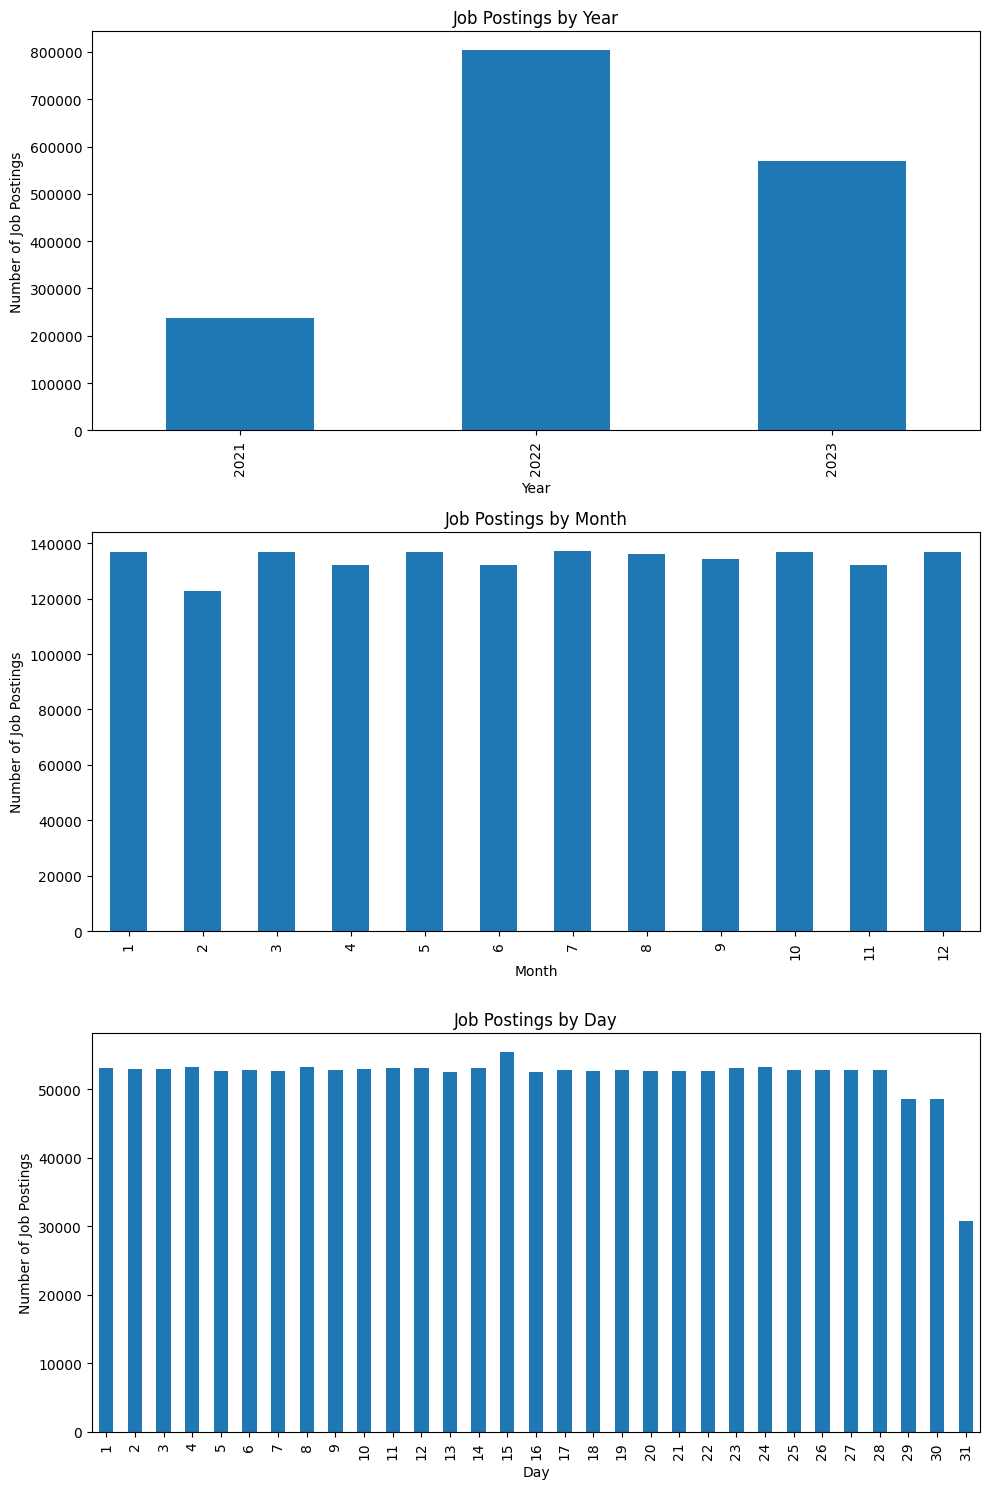

In [57]:
df['year'] = df['Job Posting Date'].dt.year
df['month'] = df['Job Posting Date'].dt.month
df['day'] = df['Job Posting Date'].dt.day
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot years
df['year'].value_counts().sort_index().plot(ax=axs[0], kind='bar')
axs[0].set_title('Job Postings by Year')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Job Postings')

# Plot months
df['month'].value_counts().sort_index().plot(ax=axs[1], kind='bar')
axs[1].set_title('Job Postings by Month')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Number of Job Postings')

# Plot days
df['day'].value_counts().sort_index().plot(ax=axs[2], kind='bar')
axs[2].set_title('Job Postings by Day')
axs[2].set_xlabel('Day')
axs[2].set_ylabel('Number of Job Postings')

plt.tight_layout()
plt.show()

In [58]:
df.drop('Job Posting Date', axis=1, inplace=True)
df.drop('month', axis=1, inplace=True)
df.drop('day', axis=1, inplace=True)

In [59]:
df.drop('Contact Person', axis=1, inplace=True)
df.drop('Contact', axis=1, inplace=True)

In [60]:
df.head()

,Qualifications,location,Country,latitude,longitude,Work Type,Company Size,Preference,Job Title,Role,Job Portal,Job Description,Benefits,skills,Responsibilities,Company,Company Profile,min_exp,max_exp,min_salary,max_salary,year
0,M.Tech,Douglas,Isle of Man,54.2361,-4.5481,Intern,26801,Female,Digital Marketing Specialist,Social Media Manager,Snagajob,Social Media Managers oversee an organizations...,"{'Flexible Spending Accounts (FSAs), Relocatio...","Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",Icahn Enterprises,"{""Sector"":""Diversified"",""Industry"":""Diversifie...",5,15,59000,99000,2022
1,BCA,Ashgabat,Turkmenistan,38.9697,59.5563,Intern,100340,Female,Web Developer,Frontend Web Developer,Idealist,Frontend Web Developers design and implement u...,"{'Health Insurance, Retirement Plans, Paid Tim...","HTML, CSS, JavaScript Frontend frameworks (e.g...","Design and code user interfaces for websites, ...",PNC Financial Services Group,"{""Sector"":""Financial Services"",""Industry"":""Com...",2,12,56000,116000,2022
2,PhD,Macao,"Macao SAR, China",22.1987,113.5439,Temporary,84525,Male,Operations Manager,Quality Control Manager,Jobs2Careers,Quality Control Managers establish and enforce...,"{'Legal Assistance, Bonuses and Incentive Prog...",Quality control processes and methodologies St...,Establish and enforce quality control standard...,United Services Automobile Assn.,"{""Sector"":""Insurance"",""Industry"":""Insurance: P...",0,12,61000,104000,2022
3,PhD,Porto-Novo,Benin,9.3077,2.3158,Full-Time,129896,Female,Network Engineer,Wireless Network Engineer,FlexJobs,"Wireless Network Engineers design, implement, ...","{'Transportation Benefits, Professional Develo...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",Hess,"{""Sector"":""Energy"",""Industry"":""Mining, Crude-O...",4,11,65000,91000,2023
4,MBA,Santiago,Chile,-35.6751,-71.5429,Intern,53944,Female,Event Manager,Conference Manager,Jobs2Careers,A Conference Manager coordinates and manages c...,"{'Flexible Spending Accounts (FSAs), Relocatio...",Event planning Conference logistics Budget man...,Specialize in conference and convention planni...,Cairn Energy,"{""Sector"":""Energy"",""Industry"":""Energy - Oil & ...",1,12,64000,87000,2022


In [61]:
df['Benefits'] = df['Benefits'].str.replace('{', '')
df['Benefits'] = df['Benefits'].str.replace('}', '')
df['Benefits'] = df['Benefits'].str.replace("'", '')
# Split the benefits into separate columns
benefits_split = df['Benefits'].str.get_dummies(sep=', ')

# Concatenate the new columns with the original dataframe
df = pd.concat([df, benefits_split], axis=1)

# Drop the original Benefits column
df.drop('Benefits', axis=1, inplace=True)

df.head()

,Qualifications,location,Country,latitude,longitude,Work Type,Company Size,Preference,Job Title,Role,Job Portal,Job Description,skills,Responsibilities,Company,Company Profile,min_exp,max_exp,min_salary,max_salary,year,Bonuses and Incentive Programs,Casual Dress Code,Childcare Assistance,Employee Assistance Programs (EAP),Employee Discounts,Employee Recognition Programs,Employee Referral Programs,Financial Counseling,Flexible Spending Accounts (FSAs),Flexible Work Arrangements,Health Insurance,Health and Wellness Facilities,Legal Assistance,Life and Disability Insurance,Paid Time Off (PTO),Parental Leave,Professional Development,Profit-Sharing,Relocation Assistance,Retirement Plans,Social and Recreational Activities,Stock Options or Equity Grants,Transportation Benefits,Tuition Reimbursement,Wellness Programs
0,M.Tech,Douglas,Isle of Man,54.2361,-4.5481,Intern,26801,Female,Digital Marketing Specialist,Social Media Manager,Snagajob,Social Media Managers oversee an organizations...,"Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",Icahn Enterprises,"{""Sector"":""Diversified"",""Industry"":""Diversifie...",5,15,59000,99000,2022,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,BCA,Ashgabat,Turkmenistan,38.9697,59.5563,Intern,100340,Female,Web Developer,Frontend Web Developer,Idealist,Frontend Web Developers design and implement u...,"HTML, CSS, JavaScript Frontend frameworks (e.g...","Design and code user interfaces for websites, ...",PNC Financial Services Group,"{""Sector"":""Financial Services"",""Industry"":""Com...",2,12,56000,116000,2022,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,PhD,Macao,"Macao SAR, China",22.1987,113.5439,Temporary,84525,Male,Operations Manager,Quality Control Manager,Jobs2Careers,Quality Control Managers establish and enforce...,Quality control processes and methodologies St...,Establish and enforce quality control standard...,United Services Automobile Assn.,"{""Sector"":""Insurance"",""Industry"":""Insurance: P...",0,12,61000,104000,2022,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3,PhD,Porto-Novo,Benin,9.3077,2.3158,Full-Time,129896,Female,Network Engineer,Wireless Network Engineer,FlexJobs,"Wireless Network Engineers design, implement, ...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",Hess,"{""Sector"":""Energy"",""Industry"":""Mining, Crude-O...",4,11,65000,91000,2023,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
4,MBA,Santiago,Chile,-35.6751,-71.5429,Intern,53944,Female,Event Manager,Conference Manager,Jobs2Careers,A Conference Manager coordinates and manages c...,Event planning Conference logistics Budget man...,Specialize in conference and convention planni...,Cairn Energy,"{""Sector"":""Energy"",""Industry"":""Energy - Oil & ...",1,12,64000,87000,2022,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [62]:
pd.set_option('display.max_columns', None)
df.head(5)

,Qualifications,location,Country,latitude,longitude,Work Type,Company Size,Preference,Job Title,Role,Job Portal,Job Description,skills,Responsibilities,Company,Company Profile,min_exp,max_exp,min_salary,max_salary,year,Bonuses and Incentive Programs,Casual Dress Code,Childcare Assistance,Employee Assistance Programs (EAP),Employee Discounts,Employee Recognition Programs,Employee Referral Programs,Financial Counseling,Flexible Spending Accounts (FSAs),Flexible Work Arrangements,Health Insurance,Health and Wellness Facilities,Legal Assistance,Life and Disability Insurance,Paid Time Off (PTO),Parental Leave,Professional Development,Profit-Sharing,Relocation Assistance,Retirement Plans,Social and Recreational Activities,Stock Options or Equity Grants,Transportation Benefits,Tuition Reimbursement,Wellness Programs
0,M.Tech,Douglas,Isle of Man,54.2361,-4.5481,Intern,26801,Female,Digital Marketing Specialist,Social Media Manager,Snagajob,Social Media Managers oversee an organizations...,"Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",Icahn Enterprises,"{""Sector"":""Diversified"",""Industry"":""Diversifie...",5,15,59000,99000,2022,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,BCA,Ashgabat,Turkmenistan,38.9697,59.5563,Intern,100340,Female,Web Developer,Frontend Web Developer,Idealist,Frontend Web Developers design and implement u...,"HTML, CSS, JavaScript Frontend frameworks (e.g...","Design and code user interfaces for websites, ...",PNC Financial Services Group,"{""Sector"":""Financial Services"",""Industry"":""Com...",2,12,56000,116000,2022,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,PhD,Macao,"Macao SAR, China",22.1987,113.5439,Temporary,84525,Male,Operations Manager,Quality Control Manager,Jobs2Careers,Quality Control Managers establish and enforce...,Quality control processes and methodologies St...,Establish and enforce quality control standard...,United Services Automobile Assn.,"{""Sector"":""Insurance"",""Industry"":""Insurance: P...",0,12,61000,104000,2022,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3,PhD,Porto-Novo,Benin,9.3077,2.3158,Full-Time,129896,Female,Network Engineer,Wireless Network Engineer,FlexJobs,"Wireless Network Engineers design, implement, ...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",Hess,"{""Sector"":""Energy"",""Industry"":""Mining, Crude-O...",4,11,65000,91000,2023,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
4,MBA,Santiago,Chile,-35.6751,-71.5429,Intern,53944,Female,Event Manager,Conference Manager,Jobs2Careers,A Conference Manager coordinates and manages c...,Event planning Conference logistics Budget man...,Specialize in conference and convention planni...,Cairn Energy,"{""Sector"":""Energy"",""Industry"":""Energy - Oil & ...",1,12,64000,87000,2022,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [63]:
df[['Sector', 'Industry', 'City', 'State', 'Zip', 'Website', 'Ticker', 'CEO']] = df['Company Profile'].str.extract(
    r'"Sector":"([^"]+)".*?"Industry":"([^"]+)".*?"City":"([^"]+)".*?"State":"([^"]+)".*?"Zip":"([^"]+)".*?"Website":"([^"]+)".*?"Ticker":"([^"]+)".*?"CEO":"([^"]+)"'
)
df.drop('Company Profile', axis=1, inplace=True)
df.head()

,Qualifications,location,Country,latitude,longitude,Work Type,Company Size,Preference,Job Title,Role,Job Portal,Job Description,skills,Responsibilities,Company,min_exp,max_exp,min_salary,max_salary,year,Bonuses and Incentive Programs,Casual Dress Code,Childcare Assistance,Employee Assistance Programs (EAP),Employee Discounts,Employee Recognition Programs,Employee Referral Programs,Financial Counseling,Flexible Spending Accounts (FSAs),Flexible Work Arrangements,Health Insurance,Health and Wellness Facilities,Legal Assistance,Life and Disability Insurance,Paid Time Off (PTO),Parental Leave,Professional Development,Profit-Sharing,Relocation Assistance,Retirement Plans,Social and Recreational Activities,Stock Options or Equity Grants,Transportation Benefits,Tuition Reimbursement,Wellness Programs,Sector,Industry,City,State,Zip,Website,Ticker,CEO
0,M.Tech,Douglas,Isle of Man,54.2361,-4.5481,Intern,26801,Female,Digital Marketing Specialist,Social Media Manager,Snagajob,Social Media Managers oversee an organizations...,"Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",Icahn Enterprises,5,15,59000,99000,2022,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,Diversified,Diversified Financials,Sunny Isles Beach,Florida,33160,www.ielp.com,IEP,David Willetts
1,BCA,Ashgabat,Turkmenistan,38.9697,59.5563,Intern,100340,Female,Web Developer,Frontend Web Developer,Idealist,Frontend Web Developers design and implement u...,"HTML, CSS, JavaScript Frontend frameworks (e.g...","Design and code user interfaces for websites, ...",PNC Financial Services Group,2,12,56000,116000,2022,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,Financial Services,Commercial Banks,Pittsburgh,Pennsylvania,15222,www.pnc.com,PNC,William S. Demchak
2,PhD,Macao,"Macao SAR, China",22.1987,113.5439,Temporary,84525,Male,Operations Manager,Quality Control Manager,Jobs2Careers,Quality Control Managers establish and enforce...,Quality control processes and methodologies St...,Establish and enforce quality control standard...,United Services Automobile Assn.,0,12,61000,104000,2022,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PhD,Porto-Novo,Benin,9.3077,2.3158,Full-Time,129896,Female,Network Engineer,Wireless Network Engineer,FlexJobs,"Wireless Network Engineers design, implement, ...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",Hess,4,11,65000,91000,2023,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,Energy,"Mining, Crude-Oil Production",New York,New York,10036,www.hess.com,HES,John B. Hess
4,MBA,Santiago,Chile,-35.6751,-71.5429,Intern,53944,Female,Event Manager,Conference Manager,Jobs2Careers,A Conference Manager coordinates and manages c...,Event planning Conference logistics Budget man...,Specialize in conference and convention planni...,Cairn Energy,1,12,64000,87000,2022,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,Energy,Energy - Oil & Gas Exploration & Production,Edinburgh,Scotland,EH2 4NH,https://www.cairnenergy.com/,CNE,Simon Thomson


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec


# Download necessary NLTK data
# nltk.download('stopwords')
# nltk.download('wordnet')

# Initialize lemmatizer and stop words
text_clumns = ['Job Description', 'skills', 'Responsibilities']
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove unwanted characters, numbers, and symbols
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize and remove stop words
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens]
    return tokens

# Apply preprocessing to the text columns
for column in text_columns:
    df[column] = df[column].apply(preprocess_text)

# Combine all text data for Word2Vec training
all_text = df[text_columns].values.flatten()
all_text = [item for sublist in all_text for item in sublist]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=[all_text], vector_size=100, window=5, min_count=1, workers=4)

# Function to get the average embedding for a document
def get_average_embedding(tokens, model, embedding_dim=100):
    valid_embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if valid_embeddings:
        return np.mean(valid_embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)

# Apply preprocessing and get embeddings
embedding_dim = 100
for column in text_columns:
    df[column + '_embedding'] = df[column].apply(lambda tokens: get_average_embedding(tokens, word2vec_model, embedding_dim))

# Concatenate the embeddings into a single DataFrame
embeddings_df = pd.DataFrame(df[text_columns[0] + '_embedding'].tolist(), index=df.index)
for column in text_columns[1:]:
    temp_df = pd.DataFrame(df[column + '_embedding'].tolist(), index=df.index)
    embeddings_df = pd.concat([embeddings_df, temp_df], axis=1)

# Concatenate the new DataFrame with the original df
df = pd.concat([df, embeddings_df], axis=1)

df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/khoulykid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/khoulykid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


KeyboardInterrupt: 